# W2D1 Tutorial 4: Return levels using Normal and GEV distributions

#### __Week 2, Day 4, Extremes & Vulnerability__
##### __Content creators:__ Matthias Aengenheyster, Joeri Reinders
##### __Content reviewers:__ TBD
##### __Content editors:__ TBD
##### __Production editors:__ TBD
##### __Our 2023 Sponsors:__ TBD

## Tutorial Objectives:

Now that we know how to create pdf for the GEV distribution we can use it to compute return values 
based on a GEV distribution.

We  compute return levels from a pdf by using the cumulative distribution function (CDF), which tells us
the chance that a randomly drawn variable from our distribution will be less than some value X (for our 
variable). Rare extreme values thus have a high chance (as most random draws will be smaller – small storms).
Again, say that there is a 99% chance that we will see a storm of 80mm or higher… than there is a 1% change
we will see a storm of at least 80mm – and given what we said above it means the 100-year storm will bring 
80mm of rain. Formally the return level is the inverse of the CDF – for here all you need to know is that 
you can compute return-levels using the function estimate_return_level_from_params(x,location,scale,shape). In this case x is the chance
a random value from our distribution is lower – so for the 100-year storm this would be 0.99; and for the
1000-year storm 0.999.  

By the end of the tutorial you will be able to:
- Estimate return levels given a quantile and the parameters of a GEV distribution
- Compare return levels plots for GEV and normal distributions

## Setup

In [6]:
# Installs

In [7]:
# # <Yosmely Bermúdez> comments
# #install dependencies
# # We need this to install eigen which is needed for SDFC to install correctly
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install eigen
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy
# !pip install texttable

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy import stats
gev = stats.genextreme

import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

In [9]:
import os, pooch

fname = 'precipitationGermany_1920-2022.csv'
if not os.path.exists(fname):
    url = "https://osf.io/xs7h6/download"
    fname = pooch.retrieve(url, known_hash=None)

data = pd.read_csv(fname, index_col=0).set_index('years')

data.columns=['precipitation']
precipitation = data.precipitation

In [10]:
fit, model = ef.fit_return_levels_sdfc(precipitation.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=10,full=True,model=True)

In [11]:
fit

<xarray.Dataset>
Dimensions:            (return period: 999, N: 10, return_period_obs: 103)
Coordinates:
  * return period      (return period) float64 1.1 2.1 3.1 ... 997.1 998.1 999.1
  * N                  (N) int64 0 1 2 3 4 5 6 7 8 9
  * return_period_obs  (return_period_obs) float64 1.01 1.02 1.03 ... 52.0 104.0
Data variables:
    return level       (return period, N) float64 19.29 21.15 ... 94.04 71.68
    mu                 (N) float64 25.29 26.72 26.94 28.0 ... 28.33 26.23 25.02
    sigma              (N) float64 7.052 6.609 7.854 8.102 ... 7.966 7.918 7.302
    xi                 (N) float64 0.06169 0.08785 0.05762 ... 0.06022 -0.02277
    return_level_obs   (return_period_obs) float64 15.6 16.2 16.9 ... 59.9 69.5

In [12]:
model

+-----------+--------+------------+--------+----------------+----------------+
| GEV (mle) |  Link  |    Type    |  coef  | Quantile 0.025 | Quantile 0.975 |
+===========+========+============+========+================+================+
| loc       | IdLink | Stationary | 26.354 | 25.081         | 28.257         |
+-----------+--------+------------+--------+----------------+----------------+
| scale     | IdLink | Stationary | 7.369  | 6.377          | 8.553          |
+-----------+--------+------------+--------+----------------+----------------+
| shape     | IdLink | Stationary | 0.047  | -0.106         | 0.119          |
+-----------+--------+------------+--------+----------------+----------------+

This utility function takes a given *quantile* and a fitted *model* and computes the corresponding return level

In [13]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.coef_
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

def estimate_return_level_from_params(quantile,loc,scale,shape):
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    return level

Now let's use this function to compute the 2-year level, which is the level of precipitation we expect with a 50% chance each year. The function needs a quantile x, and the three GEV parameters: location, scale, and shape. The output of the function is the return level at that quantile. 
For example the 90th quantile (x=0.9) would give the 10-year precipitation value (10% change of seeing it every year).

In [14]:
estimate_return_level(0.5,model)

29.07804011079915

In [15]:
stats.genextreme.ppf(0.5,-model.shape.mean(),loc=model.loc.mean(),scale=model.scale.mean())

29.078040110799137

It is probably easier to replace x with a variable called “rp” (= return period). You can use the formula 1-(1/return period)
to compute rp. So a 100-year storm would be 1-(1/100) = 0.99. Compute the 100- and 1000-year storm. 

In [16]:
estimate_return_level(1-1/80,model)

62.16649374058934

In [17]:
estimate_return_level(1-1/1000,model)

86.51930945981249

Now we will make a figure in which we plot return-levels against return-periods:
1. Create vector “periods” which is a sequence of 2 to a 1000-years (in steps of 2).
2. Create a vector “levels” which is the associated return-levels for those return periods.
3. Plot them against each other. Typically the return periods go on the x-axis at a log-scale.


[]

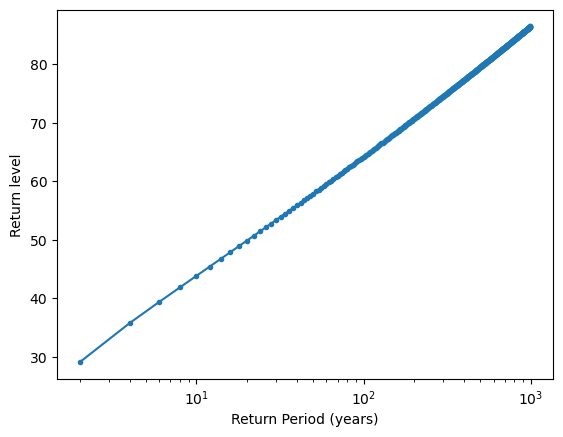

In [18]:
periods = np.arange(2,1000,2)
quantiles = 1-1/periods
levels = estimate_return_level(quantiles,model)
# plt.plot(x,estimate_return_level(x,model))
plt.plot(periods,levels,'.-')
plt.xlabel('Return Period (years)')
plt.ylabel('Return level')

plt.semilogx()

It would be interesting to compare the return levels from a normal and GEV distribution. Compute the 
50-,100-,500- and 1000-year based on a normal distribution and based on the GEV distribution
like above. 

You can use the stats.norm.ppf and stats.genextreme.ppf functions: The "Percent point function" (ppf) is the inverse of the CDF function: It takes the quantiles (and the distribution parameters) and returns the values. 
For the normal distribution, you need mean and standard deviation. 
For the GEV distribution, you need shape, location, and scale. Note that there are two sign conventions for the shape parameter - You will have to multiply the shape from the fit above by -1.

In [19]:
years = np.array([50,100,500,1000])
quantiles = 1-1/years

df = pd.DataFrame(index=years)
df['Normal Distribution'] = stats.norm.ppf(quantiles,loc=precipitation.mean(), scale=precipitation.std())
df['GEV'] = stats.genextreme.ppf(quantiles,-model.shape.mean(),loc=model.loc.mean(),scale=model.scale.mean())

In [20]:
df

,Normal Distribution,GEV
50,51.359942,57.922623
100,54.066103,64.209805
500,59.544102,79.554969
1000,61.649382,86.519309


## Excercise: Plot and compare return levels for Normal and GEV distributions
Create a return time plot that plots
1. the empirical return level
2. the estimate based on a normal distribution
3. the estimate based on a GEV distribution

Note that the empirical return level is contained in the "return_level_obs" variable of the "fit" dataset:

In [21]:
fit.return_level_obs

<xarray.DataArray 'return_level_obs' (return_period_obs: 103)>
array([15.6, 16.2, 16.9, 17.9, 18.1, 18.7, 19.6, 19.7, 20.1, 20.3, 20.6,
       20.8, 20.9, 21. , 21. , 21.2, 21.2, 21.2, 21.3, 21.9, 22. , 22.4,
       22.4, 22.7, 22.7, 23.2, 23.4, 23.5, 23.5, 23.8, 24.5, 24.5, 24.7,
       24.9, 25.4, 25.4, 25.6, 26.1, 26.2, 26.2, 26.3, 26.7, 27.4, 27.7,
       27.8, 28.8, 28.9, 29.4, 29.6, 29.9, 30.2, 30.3, 30.9, 31.1, 31.2,
       31.2, 31.3, 31.4, 31.4, 31.6, 32.4, 32.4, 32.4, 32.5, 32.6, 33. ,
       33.3, 33.6, 34.2, 34.6, 34.7, 34.7, 34.8, 35. , 35.3, 35.8, 35.9,
       36.2, 36.4, 36.4, 36.5, 36.6, 37.3, 37.4, 37.4, 37.5, 38.6, 39.6,
       40.2, 40.6, 40.7, 41.9, 44. , 44.4, 45.4, 46.5, 48. , 49. , 49.8,
       55.3, 57.4, 59.9, 69.5])
Coordinates:
  * return_period_obs  (return_period_obs) float64 1.01 1.02 1.03 ... 52.0 104.0

### student

In [22]:
...

Ellipsis

### solution

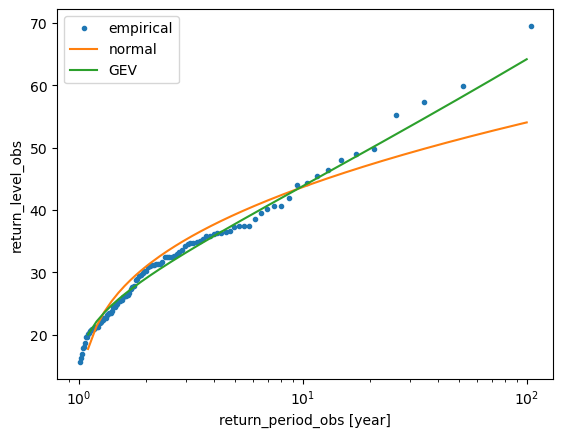

In [23]:
fit.return_level_obs.plot.line('.')
years = np.arange(1.1,100,0.1)
plt.plot(years,stats.norm.ppf(1-1/years,loc=precipitation.mean(), scale=precipitation.std()))
plt.plot(years,stats.genextreme.ppf(1-1/years,-model.shape.mean(),loc=model.loc.mean(),scale=model.scale.mean()))

plt.semilogx()

plt.legend(['empirical','normal','GEV'])

### What can you say about the plot and how the distributions describe the data? How do the distributions differ? At short/long return periods? What will happen at even longer return periods?

## Optional extra task: Implement your own bootstrapping algorithm
We have used the pre-written function ef.fit_return_levels_sdfc to fit the GEV distribution to the data, compute confidence intervals and the like. You may find it instructive to try and implement such an algorithm from scratch. 
One pathway would be the following:
1. Start from the 'gev' function (scipy.stats.genextreme). It can be used to fit by GEV parameters by stats.genextreme.fit(data), and returns the three parameters (note a sign change in the shape parameter - different conventions exist!)
2. Check how many observations there are in the data, let's call this number N.
3. Resample the data by drawing N samples out of the data, with replacing - this creates an artificial ensemble, different from the true data due to the resampling.
4. Estimate the parameters for each resampling.
5. Use the stats.genextreme.ppf for each parameter set to compute the return level for each one.
6. Visualize the resulting uncertainty bands, e.g. by plotting many lines or computing confidence intervals using np.quantile.


### solution

In [24]:
params = []
for i in range(1000):
    params.append(gev.fit(np.random.choice(precipitation,size=precipitation.size,replace=True)))

In [25]:
print('Mean estimate and 95% confidence intervals')
[
    np.mean(np.array(params),axis=0),
    np.quantile(np.array(params),[0.025,0.975],axis=0)
]

Mean estimate and 95% confidence intervals


[array([-0.03880629, 26.46145569,  7.3105464 ]),
 array([[-0.21382168, 24.72881586,  6.19726218],
        [ 0.12307466, 28.27553679,  8.42557413]])]

In [26]:
years = np.arange(1.1,1000,0.1)
levels = []
for i in range(1000):
    levels.append(gev.ppf(1-1/years,*params[i]))
levels = np.array(levels)

Text(0, 0.5, 'return level (mm/day)')

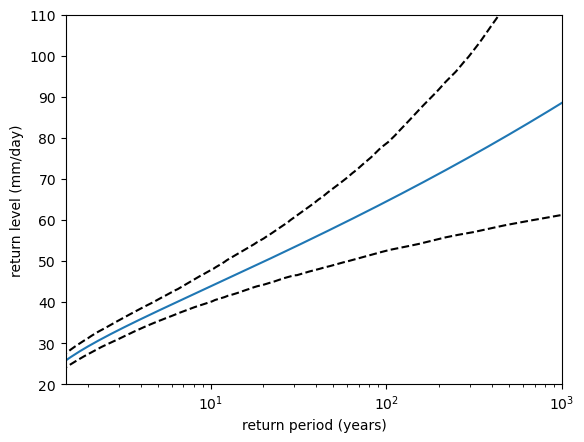

In [28]:
plt.plot(years,levels.mean(axis=0))
plt.plot(years,np.quantile(levels,[0.025,0.975],axis=0).T,'k--')
plt.semilogx()
plt.xlim(1.5,1000)
plt.ylim(20,110)
plt.xlabel('return period (years)')
plt.ylabel('return level (mm/day)')